In [9]:
from torchvision.datasets import VOCSegmentation
from PIL import Image   
from torchvision.transforms.functional import to_tensor, to_pil_image

import torch
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
%matplotlib inline

## Dataset

In [2]:
class myVOCSegmentation(VOCSegmentation):
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])

        if self.transforms is not None:
            augmented = self.transforms(image=np.array(img), mask=np.array(target))
            img = augmented['image']
            target = augmented['mask']                  
            target[target>20] = 0

        img = to_tensor(img)            
        target = torch.from_numpy(target).type(torch.long)
        
        return img, target

In [5]:
from albumentations import (
    HorizontalFlip,
    Compose,
    Resize,
    Normalize)

mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
h,w = 520, 520

transform_train = Compose([Resize(h, w),
                           HorizontalFlip(p=0.5), 
                           Normalize(mean=mean, std=std)])

transform_val = Compose([Resize(h, w),
                         Normalize(mean=mean, std=std)])    

In [6]:
path2data="E:/data/"

train_ds = myVOCSegmentation(path2data, 
                             year='2012', 
                             image_set='train', 
                             download=True, # True면 path2data에 다운로드됨
                             transforms=transform_train) 

print(len(train_ds)) 

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting E:/data/VOCtrainval_11-May-2012.tar to E:/data/
1464


In [7]:
val_ds = myVOCSegmentation(path2data, 
                         year='2012', 
                         image_set='val', 
                         download=True, 
                         transforms=transform_val)

print(len(val_ds)) 

Using downloaded and verified file: E:/data/VOCtrainval_11-May-2012.tar
Extracting E:/data/VOCtrainval_11-May-2012.tar to E:/data/
1449


In [11]:
img, mask = val_ds[0]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(), torch.max(mask))

torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6400)
torch.Size([520, 520]) torch.LongTensor tensor(1)


## DataLoader

In [12]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False) 

In [14]:
train_dl

In [13]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([4, 3, 520, 520]) torch.float32
torch.Size([4, 520, 520]) torch.int64


In [15]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 3, 520, 520]) torch.float32
torch.Size([8, 520, 520]) torch.int64


## Model

In [20]:
# DeepLabV3 with ResNet101 backbone
from torchvision.models.segmentation import deeplabv3_resnet101

# DeepLabV3 with MobileNetV3 backbone
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

# Mask R CNN with ResNet50 & FPN backbone
from torchvision.models.detection import maskrcnn_resnet50_fpn

import torch

In [17]:
model= deeplabv3_resnet101(pretrained=True, num_classes=21)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\Moon/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

## Loss & Optimizer

In [21]:
from torch import nn

criterion = nn.CrossEntropyLoss(reduction="sum")

In [24]:
from torch import optim

opt = optim.Adam(model.parameters(), lr=1e-6)

In [25]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), None

In [26]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20, verbose=1)

In [27]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=1e-06


## Training

In [28]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        
        output = model(xb)["out"]
        loss_b, _ = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if sanity_check is True:
            break
    
    loss = running_loss / float(len_data)
    
    return loss, None

In [30]:
import copy

def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    
    loss_history = {
         "train": [],
         "val": []}
    
    metric_history = {
         "train": [],
         "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')    
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        print("train loss: %.6f" %(train_loss))
        print("val loss: %.6f" %(val_loss))
        print("-"*10) 
        
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history      

In [32]:
import os

opt = optim.Adam(model.parameters(), lr=1e-6)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20, verbose=1)

path2models= "E:/deeplabv3_resnet101/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 150,
    "optimizer": opt,
    "loss_func": criterion,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models + "sanity_weights.pt",
}

model, loss_hist, _ = train_val(model, params_train)

Epoch 0/149, current lr=1e-06
Copied best model weights!
train loss: 162.070654
val loss: 229.093319
----------
Epoch 1/149, current lr=1e-06
train loss: 102.490565
val loss: 238.659075
----------
Epoch 2/149, current lr=1e-06
train loss: 72.270289
val loss: 243.710964
----------
Epoch 3/149, current lr=1e-06
train loss: 326.616120
val loss: 238.652670
----------
Epoch 4/149, current lr=1e-06
train loss: 106.666944
val loss: 232.583010
----------
Epoch 5/149, current lr=1e-06
train loss: 137.779777
val loss: 242.126229
----------
Epoch 6/149, current lr=1e-06
train loss: 130.441193
val loss: 241.697550
----------
Epoch 7/149, current lr=1e-06
train loss: 518.219561
val loss: 236.990489
----------
Epoch 8/149, current lr=1e-06
train loss: 642.410476
val loss: 241.244004
----------
Epoch 9/149, current lr=1e-06
train loss: 225.123591
val loss: 247.019949
----------
Epoch 10/149, current lr=1e-06
train loss: 398.565488
val loss: 246.633174
----------
Epoch 11/149, current lr=1e-06
train l

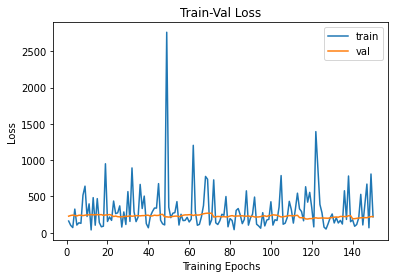

In [33]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

## Inference

In [126]:
seg_model = deeplabv3_resnet101(pretrained=True, num_classes=21)
seg_model.load_state_dict(torch.load('E:/deeplabv3_resnet101/sanity_weights.pt'))
seg_model = seg_model.to(device)
seg_model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [127]:
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        yb_pred = seg_model(xb)
        yb_pred = yb_pred['out'].cpu()
        yb_pred = torch.argmax(yb_pred, axis=1)
        break
        
print(yb_pred.shape)

torch.Size([8, 520, 520])


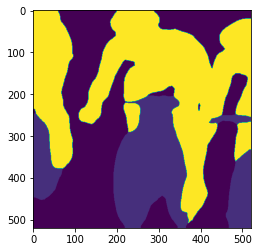

In [129]:
plt.imshow(yb_pred[4])

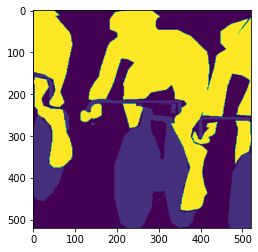

In [132]:
plt.imshow(yb[4])  # GT